# Create dictionaries for steamlit app data

use lewagon pyenv for any case

In [1]:
import pandas as pd


---

# original data


In [2]:
raw = pd.read_csv('../raw_data/recs2020_public_v6.csv')


In [3]:
# these columns are currently in the model
model_columns = ["REGIONC", "state_name", "BA_climate", "TYPEHUQ", "STORIES", "YEARMADERANGE", "NCOMBATH", "NHAFBATH", "TOTROOMS"#, "WALLTYPE", "ROOFTYPE"
                 , "WINDOWS",
           "SWIMPOOL", "NUMFRIG", "MICRO", "DISHWASH", "CWASHER", "DRYER", "TVCOLOR", "DESKTOP", "NUMLAPTOP",
           "TELLWORK","HEATHOME", "EQUIPM", "NUMPORTEL", "AIRCOND", "LGTIN1TO4", "LGTIN4TO8", "LGTINMORE8", "SMARTMETER", "SOLAR", "NHSLDMEM", "SQFTEST"
          #,"KWH"
           ]


In [4]:
#! pip install openpyxl


In [3]:
codebook = pd.read_excel(
    '../raw_data/RECS 2020 Codebook for Public File - v6.xlsx'
    , header=1)
codebook.head()


,Variable,Type,Description and Labels,Response Codes,Section
0,DOEID,Num,Unique identifier for each respondent,100001-118496,ADMIN
1,REGIONC,Char,Census Region,Midwest\nNortheast\nSouth\nWest,GEOGRAPHY
2,DIVISION,Char,"Census Division, Mountain Division is divided ...",East North Central\nEast South Central\nMiddle...,GEOGRAPHY
3,STATE_FIPS,Char,State Federal Information Processing System Code,state_dictionary!A1,GEOGRAPHY
4,state_postal,Char,State Postal Code,state_dictionary!A1,GEOGRAPHY


In [6]:
# this is current dict from user input
user_dict = {
  "TYPEHUQ": 1,
  "NHSLDMEM": 1,
  "state_name": "Alabama",
  "REGIONC": "SOUTH",
  "SQFTEST": 240,
  "STORIES": 1,
  "YEARMADERANGE": 1,
  "NCOMBATH": 0,
  "NHAFBATH": 0,
  "TOTROOMS": 1,
  "WALLTYPE": 1,
  "ROOFTYPE": 1,
  "WINDOWS": 1,
  "SWIMPOOL": 1,
  "SOLAR": 1,
  "SMARTMETER": 1,
  "TELLWORK": 1,
  "TELLDAYS": 0,
  "DESKTOP": 0,
  "NUMLAPTOP": 0,
  "TVCOLOR": 0,
  "DISHWASH": 1,
  "MICRO": 0,
  "CWASHER": 1,
  "DRYER": 1,
  "LGTIN1TO4": 0,
  "LGTIN4TO8": 0,
  "LGTINMORE8": 0,
  "AIRCOND": 1,
  "EQUIPM": 3,
  "HEATHOME": 1,
  "NUMPORTEL": 0,
  "NUMPORTAC": 0
}
user_features = pd.DataFrame({k:[v] for k,v in user_dict.items()})
print(f'this columns are too many: {set(user_features.columns).difference(model_columns)}')
print(f'this columns are missing: {set(model_columns).difference(user_features.columns)}')


this columns are too many: {'TELLDAYS', 'NUMPORTAC', 'ROOFTYPE', 'WALLTYPE'}
this columns are missing: {'BA_climate', 'NUMFRIG'}


---

## encode climate

Assign the most frequent climate to state name

Thanks GPT

In [7]:
mycols = ['state_name','BA_climate']
state2climate = raw[mycols].reset_index().groupby(mycols).count().reset_index()
climate_dict = state2climate.groupby('state_name')['BA_climate'].agg(lambda x: x.value_counts().idxmax()).to_dict()


---

## precompute feature dict

In [8]:
# these features were selected by hand (csv imported from xls file on google drive)
#selected = pd.read_csv('../csv/selected_features.csv', index_col=0)

## use functions from Diego instead
selected = codebook.loc[codebook.Variable.isin(model_columns)]
selected.head()


,Variable,Type,Description and Labels,Response Codes,Section
1,REGIONC,Char,Census Region,Midwest\nNortheast\nSouth\nWest,GEOGRAPHY
5,state_name,Char,State Name,state_dictionary!A1,GEOGRAPHY
6,BA_climate,Char,Building America Climate Zone,Cold\nHot-Dry\nHot-Humid\nMarine\nMixed-Dry\nM...,ADMIN
13,TYPEHUQ,Num,Type of housing unit,1 Mobile home\n2 Single-family house detached ...,YOUR HOME
21,STORIES,Num,Number of stories in a single-family home,1 One story\n2 Two stories\n3 Three stories\n4...,YOUR HOME


In [9]:
selected.info()


<class 'pandas.core.frame.DataFrame'>
Index: 31 entries, 1 to 294
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Variable                31 non-null     object
 1   Type                    31 non-null     object
 2   Description and Labels  31 non-null     object
 3   Response Codes          31 non-null     object
 4   Section                 31 non-null     object
dtypes: object(5)
memory usage: 1.5+ KB


In [10]:
selected.Variable.unique()


array(['REGIONC', 'state_name', 'BA_climate', 'TYPEHUQ', 'STORIES',
       'YEARMADERANGE', 'NCOMBATH', 'NHAFBATH', 'TOTROOMS', 'WINDOWS',
       'SWIMPOOL', 'NUMFRIG', 'MICRO', 'DISHWASH', 'CWASHER', 'DRYER',
       'TVCOLOR', 'DESKTOP', 'NUMLAPTOP', 'TELLWORK', 'HEATHOME',
       'EQUIPM', 'NUMPORTEL', 'AIRCOND', 'LGTIN1TO4', 'LGTIN4TO8',
       'LGTINMORE8', 'SMARTMETER', 'SOLAR', 'NHSLDMEM', 'SQFTEST'],
      dtype=object)

In [11]:
# precompute dicts
val_cols = ['Description and Labels','Response Codes']
key_col=['Variable']
label_dict = selected.set_index(key_col)[val_cols[0]].to_dict()
values_dict = selected.set_index(key_col)[val_cols[1]].to_dict()


In [12]:
len(label_dict)


31

In [13]:
# which things in which section
#sections = list(selected.Section.unique())

section_df = (codebook[['Variable','Section']]
                .groupby('Section')
                .agg(lambda x: list(x))
                .reset_index()
                )
section_df.head()


,Section,Variable
0,ADMIN,"[DOEID, BA_climate, IECC_climate_code, UATYP10]"
1,AIR CONDITIONING,"[AIRCOND, COOLAPT, ACEQUIPM_PUB, ACEQUIPAGE, A..."
2,APPLIANCES,"[NUMFRIG, SIZRFRI1, TYPERFR1, AGERFRI1, ICE, S..."
3,ELECTRONICS,"[TVCOLOR, TVSIZE1, TVTYPE1, TVUSE1, TVONWD1, T..."
4,ENERGY ASSISTANCE,"[SCALEB, SCALEG, SCALEE, PAYHELP, NOHEATBROKE,..."


#### Which feature belongs to each section

In [14]:
section_dict = section_df.set_index('Section')['Variable'].to_dict()


---
## Define feature types 

In [15]:
# purely selectbox features
# like 'SOUTH'
selectbox_features = selected['Variable'][ (selected['Response Codes'].str.contains('\n')) & (selected['Type']=='Char')].to_list()
selectbox_features.remove('REGIONC')
selectbox_features.remove('BA_climate') # inferred
print(f'selectbox_features={selectbox_features}')

# purely numeric features
# TODO extract range and put reasonable defaults
# like '0 - 90' or '0-90'
numeric_features = selected['Variable'][selected['Response Codes'].str.match('[0-9]+\s*-\s*[0-9]+$')].to_list()
print(f'numeric_features={numeric_features}')

# features whihc are numeric but are input through dropdown selectbox
# like '1 - 9\n-2 Not applicable'
numeric_features_dropdown = selected['Variable'][selected['Response Codes'].str.match('[0-9]+\s*-\s*[0-9]+\n')].to_list()
print(f'numeric_features_dropdown = {numeric_features_dropdown}')

# numeric selectbox features
# like "1 Yes\n0 No\n-4 Don't Know"
num_checkbox_features = selected['Variable'][ (selected['Response Codes'].str.contains('\n')) & (selected['Type']=='Num')].to_list()
# quick and ugly fix
for feature in numeric_features_dropdown:
    num_checkbox_features.remove(feature)
print(f'num_checkbox_features = {num_checkbox_features}')


selectbox_features=[]
numeric_features=['NCOMBATH', 'NHAFBATH', 'TOTROOMS', 'NUMFRIG', 'MICRO', 'TVCOLOR', 'DESKTOP', 'NUMLAPTOP', 'LGTIN1TO4', 'LGTIN4TO8', 'LGTINMORE8', 'NHSLDMEM', 'SQFTEST']
numeric_features_dropdown = ['NUMPORTEL']
num_checkbox_features = ['TYPEHUQ', 'STORIES', 'YEARMADERANGE', 'WINDOWS', 'SWIMPOOL', 'DISHWASH', 'CWASHER', 'DRYER', 'TELLWORK', 'HEATHOME', 'EQUIPM', 'AIRCOND', 'SMARTMETER', 'SOLAR']


---
### create mappings for numeric selectbox features

In [16]:
mapped_features={}
for feature in num_checkbox_features:
    mapped_features[feature]=dict(val.split(' ', 1)[::-1] for val in values_dict.get(feature).split('\n'))
for feature in numeric_features_dropdown:
    str_range, text  = values_dict[feature].split('\n')
    d = {str(k):str(k) for k in range(int(str_range.split(' - ')[-1])+1)}
    d.update({text.split(' ',1)[1]:text.split(' ',1)[0]})
    mapped_features[feature] = d


---

## create state dictionary

In [4]:
state_dictionary = pd.read_csv('../csv/state_dictionary.csv')
state_dictionary.head(1)


,STATE_FIPS,state_postal,state_name
0,1,AL,Alabama


In [18]:
#state_dictionary.drop(columns='STATE_FIPS').set_index('state_postal').to_dict('state_name')

#{code:state for code, state in zip(state_dictionary.state_postal, state_dictionary.state_name)}
# faster
#df.set_index(KEY).to_dict()[VALUE]
#https://stackoverflow.com/questions/17426292/how-to-create-a-dictionary-of-two-pandas-dataframe-columns#17426500


In [5]:
states = state_dictionary.set_index('state_postal')['state_name'].to_dict()


In [6]:
# map region from state
state_to_region = raw[['state_name','REGIONC']].drop_duplicates().set_index('state_name')['REGIONC'].to_dict()


In [21]:
print(f'label_dict = {label_dict}')
print(f'values_dict = {values_dict}')
print('# U.S. states selector')
print(f'states ={states}')
print('# state to region mapper')
print(f'state_to_region={state_to_region}')
print('# state to most frequent climate mapper')
print(f'climate_dict = {climate_dict}')
print('# section to features mapper')
print(f'section_dict = {section_dict}')
#print('-------------------')


label_dict = {'REGIONC': 'Census Region', 'state_name': 'State Name', 'BA_climate': 'Building America Climate Zone', 'TYPEHUQ': 'Type of housing unit', 'STORIES': 'Number of stories in a single-family home', 'YEARMADERANGE': 'Range when housing unit was built', 'NCOMBATH': 'Number of full bathrooms (top-coded)', 'NHAFBATH': 'Number of half bathrooms (top-coded)', 'TOTROOMS': 'Total number of rooms in the housing unit, excluding bathrooms; a derived variable', 'WINDOWS': 'Number of windows', 'SWIMPOOL': 'Has swimming pool', 'NUMFRIG': 'Number of refrigerators used', 'MICRO': 'Number of microwaves ', 'DISHWASH': 'Has dishwasher', 'CWASHER': 'Has clothes washer in home', 'DRYER': 'Has clothes dryer in home', 'TVCOLOR': 'Number of televisions used', 'DESKTOP': 'Number of desktop computers used', 'NUMLAPTOP': 'Number of laptop computers used', 'TELLWORK': 'Any household member teleworking', 'HEATHOME': 'Space heating equipment used', 'EQUIPM': 'Main space heating equipment type', 'NUMPORTEL

In [22]:
any([x in [1,2,3] for x in [1,2]])


True

---

#### delete Non applicable and Dont know

In [23]:
# loop over dictionary of dictionaries
for feature, value in mapped_features.items():
    for key in ["Not applicable", "Don't Know"]:
        if key in value.keys():
            print(feature,value)
            del value[key]
            print(feature,value)


STORIES {'One story': '1', 'Two stories': '2', 'Three stories': '3', 'Four or more stories': '4', 'Split-level': '5', 'Not applicable': '-2'}
STORIES {'One story': '1', 'Two stories': '2', 'Three stories': '3', 'Four or more stories': '4', 'Split-level': '5'}
SWIMPOOL {'Yes': '1', 'No': '0', 'Not applicable': '-2'}
SWIMPOOL {'Yes': '1', 'No': '0'}
EQUIPM {'Central furnace ': '3', 'Steam or hot water system with radiators or pipes ': '2', 'Central heat pump': '4', 'Ductless heat pump, also known as a “mini-split”': '13', 'Built-in electric units installed in walls, ceilings, baseboards, or floors': '5', 'Built-in room heater burning gas or oil': '7', 'Wood or pellet stove ': '8', 'Portable electric heaters': '10', 'Other ': '99', 'Not applicable': '-2'}
EQUIPM {'Central furnace ': '3', 'Steam or hot water system with radiators or pipes ': '2', 'Central heat pump': '4', 'Ductless heat pump, also known as a “mini-split”': '13', 'Built-in electric units installed in walls, ceilings, basebo

In [24]:
print(f'mapped_features = {mapped_features}')


mapped_features = {'TYPEHUQ': {'Mobile home': '1', 'Single-family house detached from any other house ': '2', 'Single-family house attached to one or more other houses (for example: duplex, row house, or townhome)': '3', 'Apartment in a building with 2 to 4 units': '4', 'Apartment in a building with 5 or more units': '5'}, 'STORIES': {'One story': '1', 'Two stories': '2', 'Three stories': '3', 'Four or more stories': '4', 'Split-level': '5'}, 'YEARMADERANGE': {'Before 1950': '1', '1950 to 1959': '2', '1960 to 1969': '3', '1970 to 1979': '4', '1980 to 1989': '5', '1990 to 1999': '6', '2000 to 2009': '7', '2010 to 2015': '8', '2016 to 2020': '9'}, 'WINDOWS': {'1 or 2 windows': '1', '3 to 5 windows': '2', '6 to 9 windows': '3', '10 to 15 windows': '4', '16 to 19 windows': '5', '20 to 29 windows': '6', '30 or more windows': '7'}, 'SWIMPOOL': {'Yes': '1', 'No': '0'}, 'DISHWASH': {'Yes': '1', 'No': '0'}, 'CWASHER': {'Yes': '1', 'No': '0'}, 'DRYER': {'Yes': '1', 'No': '0'}, 'TELLWORK': {'Yes'

---

### binary features

In [25]:
# yes no features - use toggle!
yes_no_features = []
for feature, value in mapped_features.items():
    if all([key in value.keys() for key in ['Yes','No']]):
            #print(feature,value)
            yes_no_features.append(feature)
print(f'yes_no_features = {yes_no_features}')


yes_no_features = ['SWIMPOOL', 'DISHWASH', 'CWASHER', 'DRYER', 'TELLWORK', 'HEATHOME', 'AIRCOND', 'SMARTMETER', 'SOLAR']


In [26]:
### remove numeric + text features since the text is imputed anyways
### overwrite with values form the app for now
numeric_features=['NCOMBATH', 'NHAFBATH', 'TOTROOMS', 'NUMFRIG', 'MICRO', 'TVCOLOR', 'DESKTOP', 'NUMLAPTOP', 'LGTIN1TO4', 'LGTIN4TO8', 'LGTINMORE8', 'NHSLDMEM', 'SQFTEST'] + ['NUMPORTEL']
#numeric_features_dropdown = ['NUMPORTEL'] # numeric
num_checkbox_features = ['TYPEHUQ', 'STORIES', 'YEARMADERANGE', 'WALLTYPE', 'ROOFTYPE', 'WINDOWS', 'SWIMPOOL', 'DISHWASH', 'CWASHER', 'DRYER', 'TELLWORK', 'HEATHOME', 'EQUIPM', 'AIRCOND', 'SMARTMETER', 'SOLAR']


In [27]:
### make features exclusive again
#print(f'num_checkbox_features = {list(set(num_checkbox_features).difference(yes_no_features))}')


In [28]:
## fix broken - just make lists by hand and hard code
## 3 columns based on input type
appliance_features = ['DESKTOP','NUMLAPTOP','TVCOLOR','LGTIN1TO4','LGTIN4TO8','LGTINMORE8'] + ['DISHWASH','MICRO','NUMFRIG', 'CWASHER','DRYER'] + ['AIRCOND','EQUIPM','HEATHOME' , 'NUMPORTEL']
l1=[]
l2=[]
l3=[]
for feature in appliance_features:
    if feature in yes_no_features:
        l1.append(feature)
    elif feature in num_checkbox_features:
        l2.append(feature)
    elif feature in numeric_features + numeric_features_dropdown:
        l3.append(feature)

print(l1)
print(l2)
print(l3)


['DISHWASH', 'CWASHER', 'DRYER', 'AIRCOND', 'HEATHOME']
['EQUIPM']
['DESKTOP', 'NUMLAPTOP', 'TVCOLOR', 'LGTIN1TO4', 'LGTIN4TO8', 'LGTINMORE8', 'MICRO', 'NUMFRIG', 'NUMPORTEL']


---

## final dataframe for testing

In [29]:
X_new = pd.DataFrame.from_dict({'feat1':[1], 'feat2':[-2]},orient='columns')
X_new


,feat1,feat2
0,1,-2


#### For the range around average estimate: 

<Axes: >

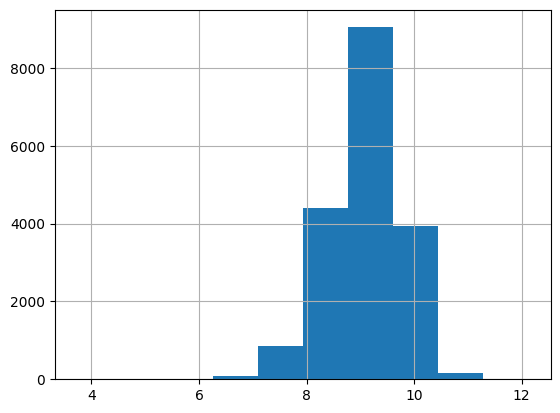

In [30]:
import numpy as np
y_log = np.log(raw.KWH)
y_log.hist()


In [31]:
np.exp(y_log.mean())


8870.991562197461

In [32]:
np.exp(y_log.quantile(0))


42.01

In [33]:
pd.DataFrame(y_log.describe()).drop('count', axis=0).assign(kwh=lambda x:np.exp(x.KWH))


,KWH,kwh
mean,9.090542,8870.991562
std,0.665891,1.946224
min,3.737908,42.010000
25%,8.686424,5921.970000
50%,9.142750,9346.434990
75%,9.557846,14155.327346
max,12.123244,184101.840000


---

### Prices dict from Diego

In [34]:
prices_per_state={'Alabama': 0.1483,
 'Alaska': 0.245,
 'Arizona': 0.1439,
 'Arkansas': 0.1267,
 'California': 0.2999,
 'Colorado': 0.1503,
 'Connecticut': 0.2925,
 'Delaware': 0.1583,
 'District of Columbia': 0.1628,
 'Florida': 0.1551,
 'Georgia': 0.1401,
 'Hawaii': 0.4152,
 'Idaho': 0.116,
 'Illinois': 0.1479,
 'Indiana': 0.141,
 'Iowa': 0.1403,
 'Kansas': 0.1346,
 'Kentucky': 0.1243,
 'Louisiana': 0.1139,
 'Maine': 0.2686,
 'Maryland': 0.1696,
 'Massachusetts': 0.28,
 'Michigan': 0.1935,
 'Minnesota': 0.1529,
 'Mississippi': 0.1305,
 'Missouri': 0.1423,
 'Montana': 0.1318,
 'Nebraska': 0.1239,
 'Nevada': 0.1694,
 'New Hampshire': 0.2331,
 'New Jersey': 0.1802,
 'New Mexico': 0.1525,
 'New York': 0.2323,
 'North Carolina': 0.1409,
 'North Dakota': 0.1277,
 'Ohio': 0.1568,
 'Oklahoma': 0.1325,
 'Oregon': 0.1313,
 'Pennsylvania': 0.1801,
 'Rhode Island': 0.2694,
 'South Carolina': 0.1452,
 'South Dakota': 0.1305,
 'Tennessee': 0.1185,
 'Texas': 0.1458,
 'Utah': 0.1185,
 'Vermont': 0.2121,
 'Virginia': 0.1479,
 'Washington': 0.1138,
 'West Virginia': 0.1438,
 'Wisconsin': 0.1732,
 'Wyoming': 0.1264}

print(f'price_per_state = {prices_per_state}')


price_per_state = {'Alabama': 0.1483, 'Alaska': 0.245, 'Arizona': 0.1439, 'Arkansas': 0.1267, 'California': 0.2999, 'Colorado': 0.1503, 'Connecticut': 0.2925, 'Delaware': 0.1583, 'District of Columbia': 0.1628, 'Florida': 0.1551, 'Georgia': 0.1401, 'Hawaii': 0.4152, 'Idaho': 0.116, 'Illinois': 0.1479, 'Indiana': 0.141, 'Iowa': 0.1403, 'Kansas': 0.1346, 'Kentucky': 0.1243, 'Louisiana': 0.1139, 'Maine': 0.2686, 'Maryland': 0.1696, 'Massachusetts': 0.28, 'Michigan': 0.1935, 'Minnesota': 0.1529, 'Mississippi': 0.1305, 'Missouri': 0.1423, 'Montana': 0.1318, 'Nebraska': 0.1239, 'Nevada': 0.1694, 'New Hampshire': 0.2331, 'New Jersey': 0.1802, 'New Mexico': 0.1525, 'New York': 0.2323, 'North Carolina': 0.1409, 'North Dakota': 0.1277, 'Ohio': 0.1568, 'Oklahoma': 0.1325, 'Oregon': 0.1313, 'Pennsylvania': 0.1801, 'Rhode Island': 0.2694, 'South Carolina': 0.1452, 'South Dakota': 0.1305, 'Tennessee': 0.1185, 'Texas': 0.1458, 'Utah': 0.1185, 'Vermont': 0.2121, 'Virginia': 0.1479, 'Washington': 0.113

---

## Some reasonable defaults (all medians / most frequent by now)

TODO: reasonables for each state

In [35]:
## for numeric inputs:
#raw[model_columns].describe().loc['50%',]#.to_dict()

defaults_numeric = (raw[numeric_features]
 .drop(columns = ['NHAFBATH','NUMLAPTOP','LGTIN4TO8', 'LGTINMORE8'])
 .describe()
 .loc['50%',]
 .astype('int')
 .to_dict()
)

print(f'defaults_numeric = {defaults_numeric}')


defaults_numeric = {'NCOMBATH': 2, 'TOTROOMS': 6, 'NUMFRIG': 1, 'MICRO': 1, 'TVCOLOR': 2, 'DESKTOP': 0, 'LGTIN1TO4': 4, 'NHSLDMEM': 2, 'SQFTEST': 1530, 'NUMPORTEL': -2}


In [36]:
# invert the mapped_features to look up actual strings
def invert_dict(feature):
    return {v:k for k,v in mapped_features[feature].items()}

inv_mapped_features = {feature:invert_dict(feature) for feature in mapped_features.keys()}
print(f'{inv_mapped_features}')


{'TYPEHUQ': {'1': 'Mobile home', '2': 'Single-family house detached from any other house ', '3': 'Single-family house attached to one or more other houses (for example: duplex, row house, or townhome)', '4': 'Apartment in a building with 2 to 4 units', '5': 'Apartment in a building with 5 or more units'}, 'STORIES': {'1': 'One story', '2': 'Two stories', '3': 'Three stories', '4': 'Four or more stories', '5': 'Split-level'}, 'YEARMADERANGE': {'1': 'Before 1950', '2': '1950 to 1959', '3': '1960 to 1969', '4': '1970 to 1979', '5': '1980 to 1989', '6': '1990 to 1999', '7': '2000 to 2009', '8': '2010 to 2015', '9': '2016 to 2020'}, 'WINDOWS': {'1': '1 or 2 windows', '2': '3 to 5 windows', '3': '6 to 9 windows', '4': '10 to 15 windows', '5': '16 to 19 windows', '6': '20 to 29 windows', '7': '30 or more windows'}, 'SWIMPOOL': {'1': 'Yes', '0': 'No'}, 'DISHWASH': {'1': 'Yes', '0': 'No'}, 'CWASHER': {'1': 'Yes', '0': 'No'}, 'DRYER': {'1': 'Yes', '0': 'No'}, 'TELLWORK': {'1': 'Yes', '0': 'No'},

In [37]:
## for categorical (dropdown)
## use mode() for most frequent value
cat_feat = numeric_features_dropdown + num_checkbox_features
defaults_categoric = (raw[cat_feat].mode().transpose()[0].replace(-2,0).replace(-4,0))
#defaults_categoric.astype('str').map(lambda x : x)
for feature in defaults_categoric.index:
    print(defaults_categoric.loc[feature,].astype(str))
    print(inv_mapped_features.get(feature))


0
{'0': '0', '1': '1', '2': '2', '3': '3', '4': '4', '5': '5', '6': '6', '7': '7', '8': '8', '9': '9'}
2
{'1': 'Mobile home', '2': 'Single-family house detached from any other house ', '3': 'Single-family house attached to one or more other houses (for example: duplex, row house, or townhome)', '4': 'Apartment in a building with 2 to 4 units', '5': 'Apartment in a building with 5 or more units'}
1
{'1': 'One story', '2': 'Two stories', '3': 'Three stories', '4': 'Four or more stories', '5': 'Split-level'}
4
{'1': 'Before 1950', '2': '1950 to 1959', '3': '1960 to 1969', '4': '1970 to 1979', '5': '1980 to 1989', '6': '1990 to 1999', '7': '2000 to 2009', '8': '2010 to 2015', '9': '2016 to 2020'}
3
None
5
None
4
{'1': '1 or 2 windows', '2': '3 to 5 windows', '3': '6 to 9 windows', '4': '10 to 15 windows', '5': '16 to 19 windows', '6': '20 to 29 windows', '7': '30 or more windows'}
0
{'1': 'Yes', '0': 'No'}
1
{'1': 'Yes', '0': 'No'}
1
{'1': 'Yes', '0': 'No'}
1
{'1': 'Yes', '0': 'No'}
0
{'1'

In [40]:
## create the mapping to the index of the most frequent category
## not very obvious since e.g. for Yes-No index for No  is 1 but the value is 0!
#list(mapped_features.get('EQUIPM').keys()).index('Other ')
list(inv_mapped_features.get('EQUIPM').keys()).index('2')


1

In [39]:
## finally, get the index of the most frequent value
cat_feat_index={}
for feature in cat_feat:
    #print(feature)
    most_freq_val = str(defaults_categoric.get(feature))
    #print(f'most frequent value: {most_freq_val}')
    idx = list(inv_mapped_features.get(feature).keys()).index(most_freq_val)
    #print(f'index:{idx}')
    cat_feat_index[feature] = idx

print(f'categorical_defaults = {cat_feat_index}')


AttributeError: 'NoneType' object has no attribute 'keys'

In [41]:
yes_no_features


['SWIMPOOL',
 'DISHWASH',
 'CWASHER',
 'DRYER',
 'TELLWORK',
 'HEATHOME',
 'AIRCOND',
 'SMARTMETER',
 'SOLAR']

In [42]:
binary_defaults = raw[yes_no_features].mode().replace(-4, 0).astype(bool).transpose()[0].to_dict()
print(f'binary_defaults={binary_defaults}')


binary_defaults={'SWIMPOOL': False, 'DISHWASH': True, 'CWASHER': True, 'DRYER': True, 'TELLWORK': False, 'HEATHOME': True, 'AIRCOND': True, 'SMARTMETER': False, 'SOLAR': False}


---

## mean kwh per state to play with th emap

In [12]:
inv_states = {v:k for k,v in states.items()}


In [14]:
raw[['state_name','KWH']].groupby('state_name').median()[['KWH']].reset_index()


,state_name,KWH
0,Alabama,13263.645
1,Alaska,6769.010
2,Arizona,12657.690
3,Arkansas,12226.165
4,California,5826.535
5,Colorado,7356.725
6,Connecticut,7230.170
7,Delaware,10098.850
8,District of Columbia,6405.660
9,Florida,13093.320


In [35]:
map_df = (raw[['KWH','state_name']]
          .groupby('state_name')
          .describe().round().astype(int)
          .reset_index()
)
map_df = map_df.set_axis(map_df.columns.map('_'.join), axis=1)
map_df


,state_name_,KWH_count,KWH_mean,KWH_std,KWH_min,KWH_25%,KWH_50%,KWH_75%,KWH_max
0,Alabama,242,14120,7136,1561,8861,13264,17907,37122
1,Alaska,311,7645,4357,918,4248,6769,10084,25870
2,Arizona,495,13884,8283,1088,8318,12658,17828,107323
3,Arkansas,268,13741,7957,1297,8623,12226,17247,74119
4,California,1152,6775,4085,475,3747,5827,8894,31613
5,Colorado,360,8493,5047,1031,4894,7357,11150,30967
6,Connecticut,294,8473,5381,791,4528,7230,10712,39216
7,Delaware,143,11210,5710,1200,7191,10099,14298,35387
8,District of Columbia,221,7420,4243,1425,4332,6406,9572,23250
9,Florida,655,14460,7987,1157,8950,13093,18124,63685


In [36]:
map_df.columns


Index(['state_name_', 'KWH_count', 'KWH_mean', 'KWH_std', 'KWH_min', 'KWH_25%',
       'KWH_50%', 'KWH_75%', 'KWH_max'],
      dtype='object')

In [44]:
## we need state code for it to show on the map
print(f'"State" : { [inv_states.get(state) for state in map_df.state_name_.to_list()] }')
print(f',"Median yearly kWh" : {map_df["KWH_50%"].round(-2).to_list()}')
print(f',"1st quartile yearly kWh" : {map_df["KWH_25%"].round(-2).to_list()}')
print(f',"3rd quartile yearly kWh" : {map_df["KWH_75%"].round(-2).to_list()}')
print(f',"Number of responders" : {map_df["KWH_count"].to_list()}')


"State" : ['AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'DC', 'FL', 'GA', 'HI', 'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD', 'MA', 'MI', 'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ', 'NM', 'NY', 'NC', 'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VT', 'VA', 'WA', 'WV', 'WI', 'WY']
,"Median yearly kWh" : [13300, 6800, 12700, 12200, 5800, 7400, 7200, 10100, 6400, 13100, 12500, 7500, 9700, 7900, 10000, 9300, 10400, 12200, 14000, 6600, 10300, 6600, 7400, 8500, 13200, 11000, 8300, 10000, 10000, 6600, 7900, 7400, 6300, 11800, 10400, 9000, 12100, 9700, 9200, 6800, 12200, 9700, 13000, 12800, 8900, 6400, 11900, 9700, 11200, 7300, 7900]
,"1st quartile yearly kWh" : [8900, 4200, 8300, 8600, 3700, 4900, 4500, 7200, 4300, 9000, 8300, 4600, 6600, 5000, 6600, 6300, 6500, 8200, 9800, 4500, 6900, 4500, 5200, 5500, 9400, 7400, 4900, 6300, 7000, 4600, 5300, 4900, 4000, 8000, 6900, 6000, 8200, 6600, 5600, 4400, 8300, 6100, 9500, 8700, 6100, 4100, 7800, 6500, 8100, 5600, 

---

## make pretty values

In [43]:
old_strings = [
    'Single-family house attached to one or more other houses (for example: duplex, row house, or townhome)'
    ,'Steam or hot water system with radiators or pipes '
    ,'Ductless heat pump, also known as a “mini-split”'
    ,'Built-in electric units installed in walls, ceilings, baseboards, or floors'
    ,'Built-in room heater burning gas or oil'
    #,
]


In [44]:
new_strings = [
    'Single-family house attached to one or more other houses'
    ,'Steam or hot water system'
    ,'Ductless heat pump'
    ,'Built-in electric units'
    ,'Built-in room heater'
    #,
]


In [45]:
# make a new pretty label dict
pretty_values = {k:v for k,v in zip(old_strings, new_strings) }
pretty_values


{'Single-family house attached to one or more other houses (for example: duplex, row house, or townhome)': 'Single-family house attached to one or more other houses',
 'Steam or hot water system with radiators or pipes ': 'Steam or hot water system',
 'Ductless heat pump, also known as a “mini-split”': 'Ductless heat pump',
 'Built-in electric units installed in walls, ceilings, baseboards, or floors': 'Built-in electric units',
 'Built-in room heater burning gas or oil': 'Built-in room heater'}

In [46]:
## make new mapped_features
for feature in mapped_features:
    #print(inv_mapped_features.get(feature))
    for value in old_strings:
        if value in inv_mapped_features.get(feature).values():
            pretty_value = pretty_values.get(value)
            key = mapped_features[feature].get(value)
            inv_mapped_features[feature][key] = pretty_value
print(f'{inv_mapped_features}')


{'TYPEHUQ': {'1': 'Mobile home', '2': 'Single-family house detached from any other house ', '3': 'Single-family house attached to one or more other houses', '4': 'Apartment in a building with 2 to 4 units', '5': 'Apartment in a building with 5 or more units'}, 'STORIES': {'1': 'One story', '2': 'Two stories', '3': 'Three stories', '4': 'Four or more stories', '5': 'Split-level'}, 'YEARMADERANGE': {'1': 'Before 1950', '2': '1950 to 1959', '3': '1960 to 1969', '4': '1970 to 1979', '5': '1980 to 1989', '6': '1990 to 1999', '7': '2000 to 2009', '8': '2010 to 2015', '9': '2016 to 2020'}, 'WINDOWS': {'1': '1 or 2 windows', '2': '3 to 5 windows', '3': '6 to 9 windows', '4': '10 to 15 windows', '5': '16 to 19 windows', '6': '20 to 29 windows', '7': '30 or more windows'}, 'SWIMPOOL': {'1': 'Yes', '0': 'No'}, 'DISHWASH': {'1': 'Yes', '0': 'No'}, 'CWASHER': {'1': 'Yes', '0': 'No'}, 'DRYER': {'1': 'Yes', '0': 'No'}, 'TELLWORK': {'1': 'Yes', '0': 'No'}, 'HEATHOME': {'1': 'Yes', '0': 'No'}, 'EQUIPM'

In [50]:
# invert back to new mapped_features
def invert_dict(feature, mapped_features):
    return {v:k for k,v in mapped_features[feature].items()}

new_mapped_features = {feature:invert_dict(feature, inv_mapped_features) for feature in inv_mapped_features.keys()}

print(f'mapped_features = {new_mapped_features}')


mapped_features = {'TYPEHUQ': {'Mobile home': '1', 'Single-family house detached from any other house ': '2', 'Single-family house attached to one or more other houses': '3', 'Apartment in a building with 2 to 4 units': '4', 'Apartment in a building with 5 or more units': '5'}, 'STORIES': {'One story': '1', 'Two stories': '2', 'Three stories': '3', 'Four or more stories': '4', 'Split-level': '5'}, 'YEARMADERANGE': {'Before 1950': '1', '1950 to 1959': '2', '1960 to 1969': '3', '1970 to 1979': '4', '1980 to 1989': '5', '1990 to 1999': '6', '2000 to 2009': '7', '2010 to 2015': '8', '2016 to 2020': '9'}, 'WINDOWS': {'1 or 2 windows': '1', '3 to 5 windows': '2', '6 to 9 windows': '3', '10 to 15 windows': '4', '16 to 19 windows': '5', '20 to 29 windows': '6', '30 or more windows': '7'}, 'SWIMPOOL': {'Yes': '1', 'No': '0'}, 'DISHWASH': {'Yes': '1', 'No': '0'}, 'CWASHER': {'Yes': '1', 'No': '0'}, 'DRYER': {'Yes': '1', 'No': '0'}, 'TELLWORK': {'Yes': '1', 'No': '0'}, 'HEATHOME': {'Yes': '1', 'N

In [ ]:
invert_dict('TYPEHUQ')
